# Assignment 7: Semantic Segmentation
Heute werden wir einfache Netzwerkarchitekturen für "Semantic Segmentation" testen. Ziel ist es dieses Paper in den Grundzügen zu implementieren: https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf. Bitte lesen!

## Daten

Es gibt einige gute Datensätze, die ihr (bei gegebener Hardware) herunterladen und benutzen könnt. Für diejenigen, die auf CPUs rechnen gilt immer der Tip: Bilder downsamplen!

Sucht Euch einen Satensatz aus: 

KITTI: http://www.cvlibs.net/download.php?file=data_semantics.zip (~300 MB, 200 Bilder)

DUS: http://www.6d-vision.com/scene-labeling (~3 GB, 500 Bilder)

MIT. http://sceneparsing.csail.mit.edu/ (~1 GB, links siehe auf Seite)

## Exc. 7.1 Fully convolutional network, no downsampling
Implementiere die in der Vorlesung besprochene Netzwerkarchitektur von aufeinanderfolgenden CONV-Schichten (stride=1, mit zero-padding), um eine Ausgabeschicht zu bekommen, die die Eingabegröße aufweist. Tip: die letzte CONV-Schicht sollte eine Tiefe haben, die zur Zahl der Klassen korrespondiert. Benutze den L2-Loss zum Labelbild (Achtung: ihr müsst dafür entweder das Labelbild oder den Ausgabetensor umformulieren).

Trainiere das Netzwerk auf den von Dir gewählten Datensatz und zeige den Verlauf des Losses, und einige zufällig gewählte Beispielbilder mit ihren vorhergesagten Segmentierungen an. (**RESULT**)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
import tensorflow as tf

from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import binarize

from keras.backend.tensorflow_backend import set_session, get_session
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, decode_predictions
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.utils.np_utils import to_categorical
from keras import optimizers

from skimage import color, io

import warnings; warnings.simplefilter('ignore')

%matplotlib inline

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

def preprocess(img):
    return color.hsv2rgb(img)

def loadImageArray(path):
    list = []
    for f in os.listdir(path):
        ext = os.path.splitext(f)[1]
        if ext.lower() not in [".png"]:
            continue
        list.append(color.hsv2rgb(io.imread(os.path.join(path, f))))
    return np.copy(list)


u6_data_semantics/training/image_2
200


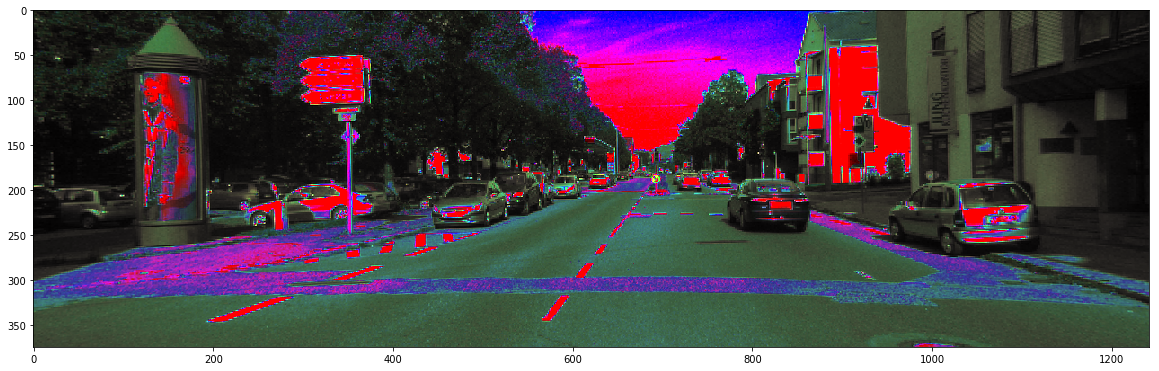

In [6]:
image_generator = ImageDataGenerator()
label_generator = ImageDataGenerator()

img_size = (38, 125)

train_image_path = os.path.join("u6_data_semantics", "training", "image_2")
train_label_path = os.path.join("u6_data_semantics", "training", "labels")

print(train_image_path)

train_images = loadImageArray(train_image_path)

print(len(train_images))

plt.figure(1, figsize=(20,7))
plt.imshow(train_images[0])
plt.show()

In [7]:
input_shape = (img_size[0], img_size[1], 3)
lr = 0.001

model = Sequential()

model.add(Conv2D(32, img_size, activation="relu", padding="same", input_shape=input_shape))
model.add(Conv2D(16, img_size, activation="relu", padding="same"))
model.add(Conv2D(12, img_size, activation="relu", padding="same"))
model.add(Conv2D(12, img_size, activation="relu", padding="same"))
model.add(Conv2D(6, img_size, activation="relu", padding="same"))
model.add(Conv2D(3, img_size, activation="relu", padding="same"))

model.compile(loss='mean_squared_error',
              optimizer=optimizers.Adam(lr=lr),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 38, 125, 32)       456032    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 38, 125, 16)       2432016   
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 38, 125, 12)       912012    
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 38, 125, 12)       684012    
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 38, 125, 6)        342006    
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 38, 125, 3)        85503     
Total params: 4,911,581
Trainable params: 4,911,581
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.save('models/ss-4406.h5')
model.save_weights('models/ss-weights-4406.h5')


# Exc. 7.2 FCN mit Bottleneck

Implementiere jetzt die Variante mit schrittweisem Down- und Upsampling, wie in der Vorlesung besprochen. Nutze dafür ein bestehendes Netzwerk (z.B. VGG16, https://keras.io/applications/#vgg16), entferne die FC-Schichten am Ende, und füge dann die Upsampling-Schichten hinzu. Wie in der vorigen Vorlesung zu Transfer Learning beschrieben, kannst Du jetzt nur den zweiten Teil trainieren und die Gewichte des ersten Teils "einfrieren".

Stelle wie oben den Verlauf des Losses dar und wähle einige Beispielbilder aus dem Testset und zeige sie mit ihrer vorhergesagten Segmentierung an. (**BONUS**)